# **Vehicle State Estimation on a Roadway**


---

**Task 1: Starter Code**













In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
from numpy.linalg import inv

**Task 2: Loading Data from Pickle file**

In [ ]:
with open('data/pt1_data.pkl', 'rb') as file:
   data = pickle.load(file)



# New Section

gt: Data object containing ground truth. with the following fields:
    

*  a: Acceleration of the vehicle, in the inertial frame  
*  v: Velocity of the vehicle, in the inertial frame
*  p: Position of the vehicle, in the inertial frame
*  alpha: Rotational acceleration of the vehicle, in the inertial frame
*  w: Rotational velocity of the vehicle, in the inertial frame   
*  r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
*  imu_f: StampedData object with the imu specific force data (given in vehicle frame)
*  imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame)
*  gnss: StampedData object with the GNSS data.
*  lidar: StampedData object with the LIDAR data (positions only)
*  data: The actual data
*  t: Timestamps in ms.











     
     
     
    

In [ ]:
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

Plotting ground truth trajectory

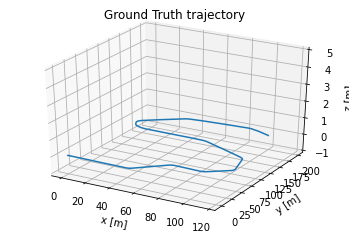

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()


Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1)

In [ ]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

Translation vector

In [ ]:
t_i_li = np.array([0.5, 0.1, 0.5])

Transform from the LIDAR frame to the vehicle (IMU) frame.

In [ ]:
lidar.data = (C_li @ lidar.data.T).T + t_i_li

**Task 3: Setting constants**

Estimated Sensor Variances

In [ ]:
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 10.00 
var_lidar = 10.00

Constants

In [ ]:
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

**Task 4: Initial Values**

In [ ]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion( euler = gt.r[0] ).to_numpy()
print("q_est[0] =", q_est[0])
C_ns_0 = Quaternion(*q_est[0]).to_mat()
print("C_ns_0 =", C_ns_0)
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

q_est[0] = [ 9.99999999e-01 -2.05063223e-05 -3.39150521e-05  5.31936712e-07]
C_ns_0 = [[ 9.99999998e-01 -1.06248248e-06 -6.78301259e-05]
 [ 1.06526437e-06  9.99999999e-01  4.10126085e-05]
 [ 6.78300822e-05 -4.10126807e-05  9.99999997e-01]]


Skew operator

In [ ]:
def skew_operator(a):
    op_mat = np.zeros([3, 3])
    op_mat[0, 1] = -a[2]
    op_mat[0, 2] = a[1]
    op_mat[1, 0] = a[2]
    op_mat[1, 2] = -a[0]
    op_mat[2, 0] = -a[1]
    op_mat[2, 1] = a[0]

    return op_mat

Quaternion product (left)

In [ ]:
def quaternion_left_prod(theta):

    ### angle normalization
    theta = angle_normalize(theta)

    ### quaternion construction based on theta info
    theta_norm = np.sqrt(theta[0] ** 2 + theta[1] ** 2 + theta[2] ** 2)
    q_w = np.sin(theta_norm / 2)
    q_v = theta / theta_norm * np.cos(theta_norm / 2)

    Omega = np.zeros([4, 4])
    Omega[0, 1:4]   = -q_v.T
    Omega[1:4, 0]   = q_v
    Omega[1:4, 1:4] = skew_operator(q_v)
    Omega = Omega + np.identity(4) * q_w

    return Omega

Quaternion product (right)

In [ ]:
def quaternion_right_prod(theta):

    ### angle normalization
    theta = angle_normalize(theta)

    ### quaternion construction based on theta info
    theta_norm = np.sqrt(theta[0] ** 2 + theta[1] ** 2 + theta[2] ** 2)
    q_w = np.sin(theta_norm / 2)
    q_v = theta / theta_norm * np.cos(theta_norm / 2)

    Omega = np.zeros([4, 4])
    Omega[0, 1:4]   = -q_v.T
    Omega[1:4, 0]   = q_v
    Omega[1:4, 1:4] = -skew_operator(q_v)
    Omega = Omega + np.identity(4) * q_w

    return Omega

**Task 5: Measurement Update for GNSS and Lidar data**

In [ ]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):

    H_k = np.zeros([3, 9])
    H_k[0:3, 0:3] = np.identity(3)

    # Kalman Gain
    K_k = p_cov_check @ H_k.T @ inv(H_k @ p_cov_check @ H_k.T + sensor_var)

    # Error state
    delta_x_k = K_k @ (y_k - p_check)

    # Correction of predicted state
    p_hat = p_check + delta_x_k[0:3]
    v_hat = v_check + delta_x_k[3:6]
    q_obj = Quaternion( euler = delta_x_k[6:9] ).quat_mult_left(q_check)
    q_hat = Quaternion(*q_obj).normalize().to_numpy()
   
    # 3.4 Corrected covariance
    p_cov_hat = ( np.identity(9) - K_k @ H_k ) @ p_cov_check

    return p_hat, v_hat, q_hat, p_cov_hat

**Task 6: Taking in the sensor data and creating estimates for our state in a loop**

In [ ]:
R_GNSS      =  np.identity(3) * var_gnss    # covariance matrix related to GNSS
R_Lidar     =  np.identity(3) * var_lidar   # covariance matrix related to Lidar
t_imu       =  imu_f.t                      # timestanps of imu
t_gnss      =  gnss.t                       # timestamps of gnss
t_lidar     =  lidar.t                      # timestamps of lidar 
F_k         =  np.identity(9)
L_k         =  np.zeros([9, 6])
L_k[3:9, :] =  np.identity(6)
Q           =  np.identity(6)               # covariance matrix related to noise of IMU
Q[0:3, 0:3] =  Q[0:3, 0:3] * var_imu_f      # covariance matrix related to special force of IMU
Q[3:6, 3:6] =  Q[3:6, 3:6] * var_imu_w      # covariance matrix related to rotational speed of IMU

for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt

    delta_t = imu_f.t[k] - imu_f.t[k - 1]
    Q_k = Q * delta_t * delta_t
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    
    #  Update state with IMU inputs
    ## Update position states
    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + delta_t ** 2 / 2 * (C_ns @ imu_f.data[k-1] + g)

    ## Update velocity states
    v_est[k] = v_est[k-1] + delta_t * (C_ns @ imu_f.data[k-1] + g)

    ## Update orientation states
    q_tmp = Quaternion( euler = (imu_w.data[k-1] * delta_t) ).quat_mult_right( q_est[k-1] )
    q_est[k] = Quaternion(*q_tmp).normalize().to_numpy()
    
    # Propagate uncertainty
    ## Linearize the motion model and compute Jacobians
    F_k[0:3, 3:6] = np.identity(3) * delta_t
    F_k[3:6, 6:9] = - skew_operator( C_ns @ imu_f.data[k-1] ) * delta_t

    ## Execute the propagate uncertainty process
    p_cov[k] = F_k @ p_cov[k-1] @ F_k.T + L_k @ Q_k @ L_k.T

    # 3. GNSS and LIDAR measurements
    
    if np.any( t_gnss == t_imu[k] ):
        t_k = np.where( t_gnss == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_GNSS, p_cov[k], gnss.data[t_k], p_est[k], v_est[k], q_est[k] )

    if np.any( t_lidar == t_imu[k] ):
        t_k = np.where( t_lidar == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_Lidar, p_cov[k], lidar.data[t_k], p_est[k], v_est[k], q_est[k] )


**Task 7: Plotting the results**

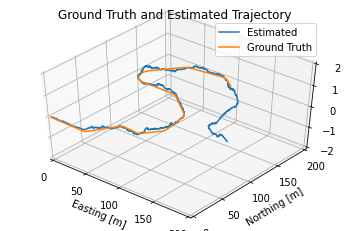

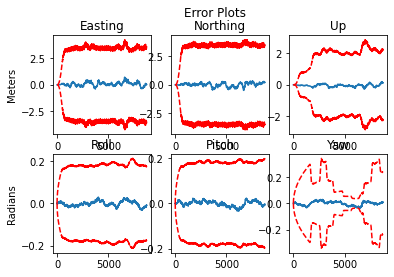

In [ ]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Conversion of estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()

p1_indices = [9000, 9400, 9800, 10200, 10600]
p1_str = ''
for val in p1_indices:
    for i in range(3):
        p1_str += '%.3f ' % (p_est[val, i])
with open('pt1_submission.txt', 'w') as file:
    file.write(p1_str)